In [ ]:
! pip install ipympl cartopy pandas xarray netcdf4 dask gpflow

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import numpy as np
import pandas as pd
import xarray as xr
import esem

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = "ClimateBench/"
# This should point to the downloaded ClimateBench data (it's already in the local path on Binder)

In [3]:
# Get one combined historical + ssp585 timeseries for now
X = xr.open_mfdataset([data_path + 'inputs_historical.nc', data_path + 'inputs_ssp585.nc']).compute()
Y = xr.concat([xr.open_dataset(data_path + 'outputs_historical.nc').sel(member=2), xr.open_dataset(data_path + 'outputs_ssp585.nc').sel(member=1)], dim='time').compute()

# Input dimensionality reduction

For this baseline example I've decided to only take the leading few EOFs of the aerosol emissions data using the `eofs` package.

In [5]:
def get_regional_df(da):
    # Roll the longitude to -180 to 180
    da = da.assign_coords(longitude=(((da.longitude + 180) % 360) - 180))
    da = da.roll(longitude=int(len(da['longitude']) / 2), roll_coords=True)

    # Get the average from four main emission regions
    north_america = da.sel(latitude=slice(25, 60), longitude=slice(-130, -60)).mean(['latitude', 'longitude']).assign_coords({'region': "NA"})
    europe = da.sel(latitude=slice(30, 75), longitude=slice(-10, 40)).mean(['latitude', 'longitude']).assign_coords({'region': "EU"})
    south_asia = da.sel(latitude=slice(5, 30), longitude=slice(65, 100)).mean(['latitude', 'longitude']).assign_coords({'region': "SA"})
    east_asia = da.sel(latitude=slice(20, 50), longitude=slice(100, 145)).mean(['latitude', 'longitude']).assign_coords({'region': "EA"})

    # Stack them back together
    ds = xr.concat([north_america, europe, south_asia, east_asia], dim='region') 
    df = ds.to_dataframe()[['SO2', 'BC']].unstack('region') # Get rid of the other variables and unstack the region dimension
    df.columns = df.columns.map(lambda x: '_'.join([str(i) for i in x])) # Flatten the multiindex
    return df * 1000*100 * 60*60*24*365 * 1e-12 * 510.1 * 1e6# kg -> Gt


In [6]:
# Bring the emissions data back together again and normalise
leading_historical_inputs = X[['CO2', 'CH4']].to_dataframe()

# Combine with aerosol EOFs
leading_historical_inputs=pd.concat([leading_historical_inputs, get_regional_df(X)], axis=1)

# Build baseline model

In [8]:
from esem import gp_model
from esem.data_processors import Whiten, Normalise

# Just a *very* simple GP with default kernel assuming all years are independant

tas_gp = gp_model(leading_historical_inputs, Y["tas"], data_processors=[Normalise()], kernel=['Linear', 'Bias' ])
tas_gp.train()

## Gather the test data

In [9]:
# Get the test data (NOT visible to contestants)
test_Y = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()
test_X = xr.open_dataset(data_path + 'inputs_ssp245.nc').compute()

# Will be hidden from contestants
tas_truth = test_Y["tas"].mean('member')

test_inputs = test_X[['CO2', 'CH4']].to_dataframe()

# Combine with aerosol EOFs
test_inputs=pd.concat([test_inputs, get_regional_df(test_X)], axis=1)

# Evaluate predictions

In [11]:
m_tas, _ = tas_gp.predict(test_inputs)


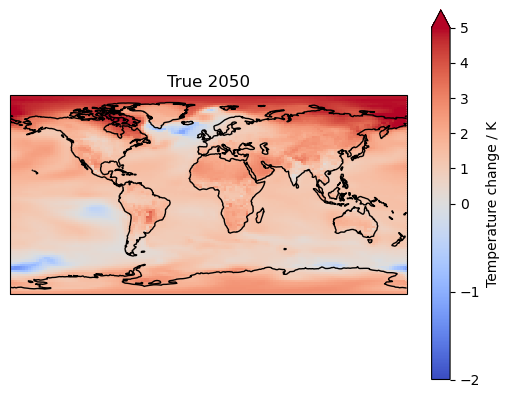

In [12]:
from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)

ax = plt.axes(projection=ccrs.PlateCarree())
tas_truth.sel(time=2050).plot(cmap="coolwarm", norm=divnorm,
                                cbar_kwargs={"label":"Temperature change / K"})
ax.set_title("True 2050")
ax.coastlines()

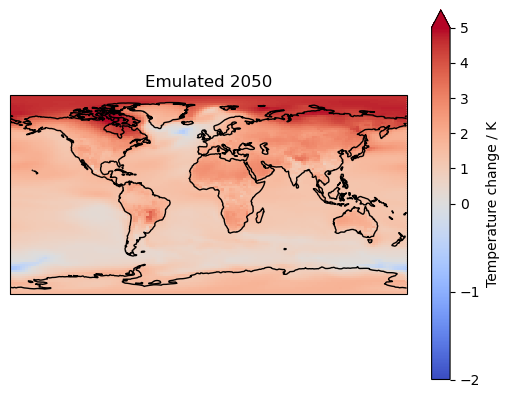

In [13]:
ax = plt.axes(projection=ccrs.PlateCarree())
m_tas.sel(sample=35).plot(cmap="coolwarm", norm=divnorm,
                            cbar_kwargs={"label":"Temperature change / K"})
ax.set_title("Emulated 2050")
ax.coastlines()
plt.show()

# Calculate some basic metrics

In [14]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth[65:85]-pred[65:85])**2).weighted(weights).mean(['lat', 'lon', 'sample', 'time'])).data

print(f"RMSE: {get_rmse(tas_truth, m_tas)}")


RMSE: 0.41290335146021434


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

class Explorer(object):
    # Adapted from https://gist.github.com/joferkington/5682690

    def __init__(self, data, **kwargs):
        self.data = data

        self.fig = plt.figure(figsize=(8, 6))
        ax = plt.axes(projection=ccrs.PlateCarree())
        self.im = data.plot(cmap="coolwarm", norm=divnorm,
                                        cbar_kwargs={"label":"Temperature change / K"})
        ax.set_title("Emulated temperature change (K)")
        ax.coastlines()

        self.sliderax = self.fig.add_axes([0.2, 0.02, 0.5, 0.04])
        self.co2 = Slider(self.sliderax, 'CO2', leading_historical_inputs['CO2'].min(), leading_historical_inputs['CO2'].max(), valinit=0)
        
        self.sliderax = self.fig.add_axes([0.2, 0.06, 0.5, 0.04])
        self.ch4 = Slider(self.sliderax, 'CH4', leading_historical_inputs['CH4'].min(), leading_historical_inputs['CH4'].max(), valinit=0)
        
        self.sliderax = self.fig.add_axes([0.2, 0.1, 0.5, 0.04])
        self.SO2_EA = Slider(self.sliderax, 'SO2 EA', leading_historical_inputs['SO2_EA'].min(), leading_historical_inputs['SO2_EA'].max(), valinit=0)

        self.co2.on_changed(self.update)
        self.ch4.on_changed(self.update)
        self.SO2_EA.on_changed(self.update)


    def update(self, i):
        m, v = tas_gp.predict(pd.DataFrame.from_dict({"CO2": [self.co2.val], 
                                                        "CH4": [self.ch4.val],
                                                        "SO2_EU": [0.],
                                                        "SO2_NA": [0.],
                                                        "SO2_EA": [self.SO2_EA.val],
                                                        "SO2_SA": [0.],
                                                        "BC_EA": [0.],
                                                        "BC_EU": [0.],
                                                        "BC_NA": [0.],
                                                        "BC_SA": [0.],
                                                        }))

        self.im.set_array(m.data.ravel())
        self.fig.canvas.draw()

    def show(self):
        plt.show()

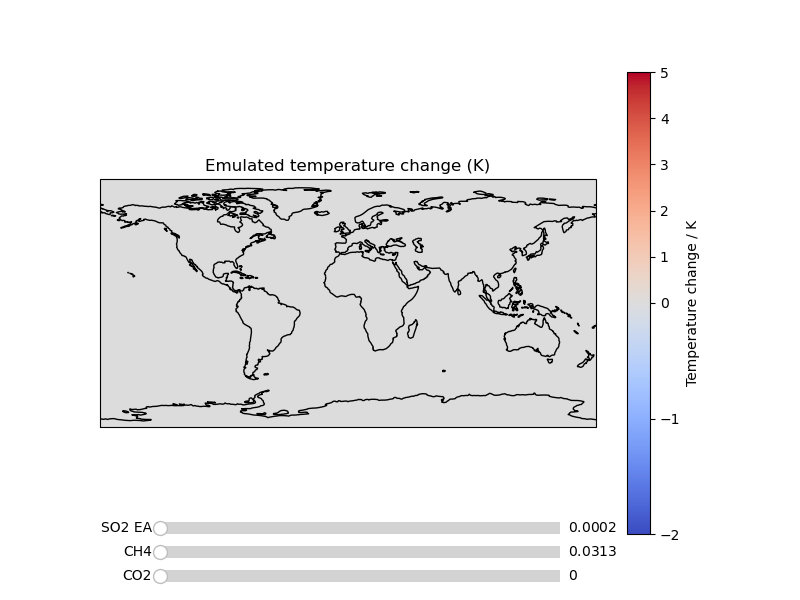

In [32]:
%matplotlib widget
ex = Explorer(xr.zeros_like(Y['tas'].sel(time=1850)), vmin=0, vmax=1)
ex.show()